In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
import warnings 
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imsave
from skimage.transform import resize 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import imgaug as ia
from imgaug import augmenters as iaa

## Dataset

In [ ]:
tfds.disable_progress_bar()

splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_examples.map(format_image).batch(1)

## Modelling

In [ ]:
def build_model():
  base_model = vgg16.VGG16(input_shape=IMAGE_SIZE + (3,), 
                      weights='imagenet', 
                      include_top=False)
  output = layers.GlobalAveragePooling2D()(base_model.output)

  output = layers.Dense(2, activation='softmax')(output)

  model = Model(base_model.input, output)

  for layer in base_model.layers[:-4]:
      layer.trainable=False

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
EPOCHS = 3
model = build_model()
model.fit(train_batches,
          epochs=EPOCHS,
          validation_data=validation_batches)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Model Interpretability


In [ ]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [layer.output for layer in model.layers[1:18]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3']


# Class activation maps (GradCAM)

In [ ]:
def get_CAM(processed_image, predicted_label, layer_name='block5_conv3'):
    model_grad = Model([model.inputs], 
                       [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)
        loss = predictions[:, predicted_label]
    
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()
    
  
    for i in range(512): 
        conv_output_values[:,:,i] *= grads_values[i]
    
    heatmap = np.mean(conv_output_values, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [ ]:
def show_random_sample():
    for img, label in test_batches.shuffle(1000).take(1):
      sample_image = img[0]
      sample_label = label[0]
    
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    
    activations = vis_model.predict(sample_image_processed)
    
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    sample_activation = activations[0][0,:,:,16]
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    
    heatmap = get_CAM(sample_image_processed, pred_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_img = sample_image.numpy()
    super_imposed_image = cv2.addWeighted(converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0)

    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return activations

Time to visualize the results

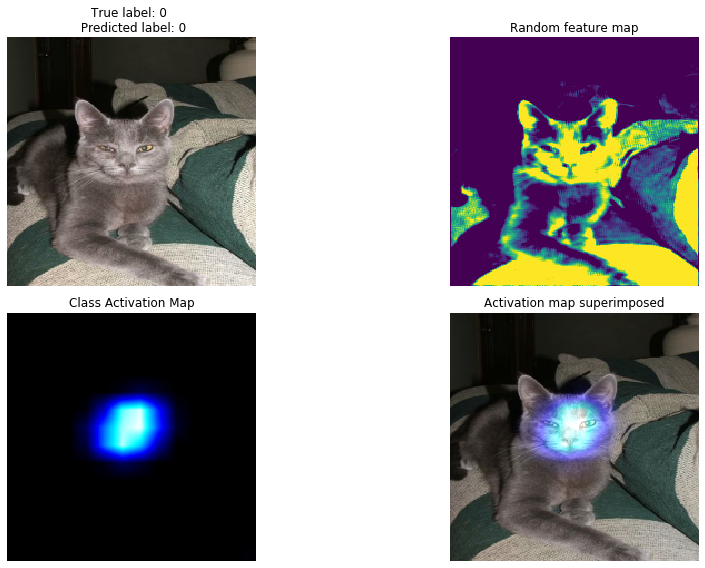

In [ ]:
activations = show_random_sample()

### Intermediate activations of layers

In [ ]:
def visualize_intermediate_activations(layer_names, activations):
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0,:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

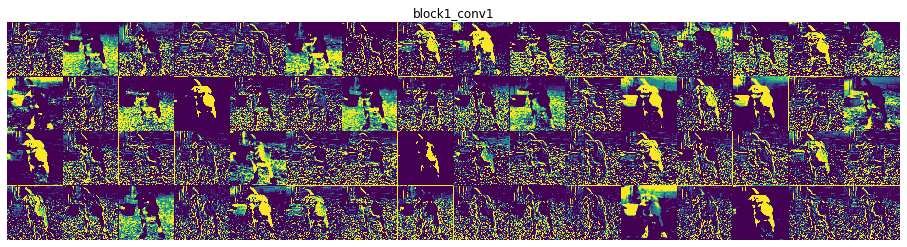

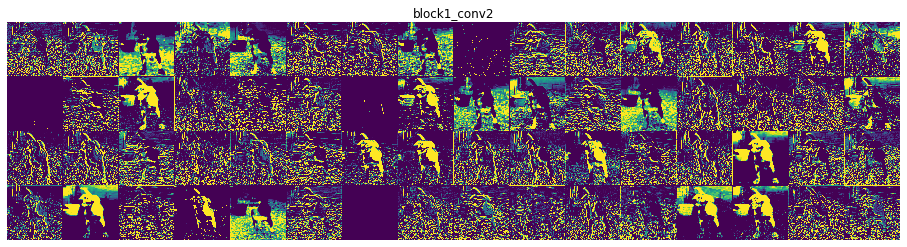

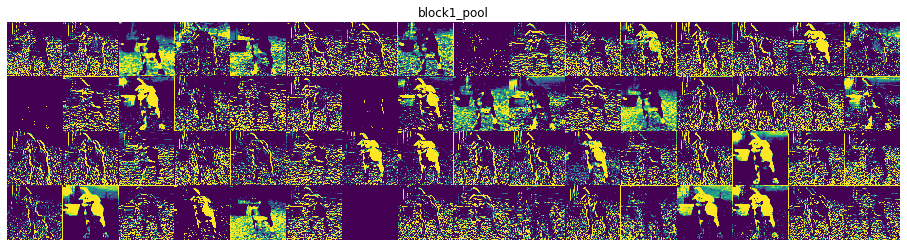

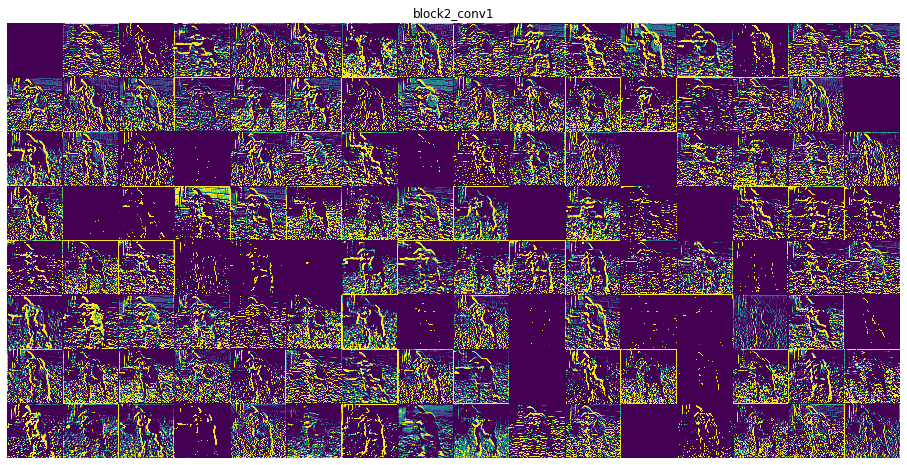

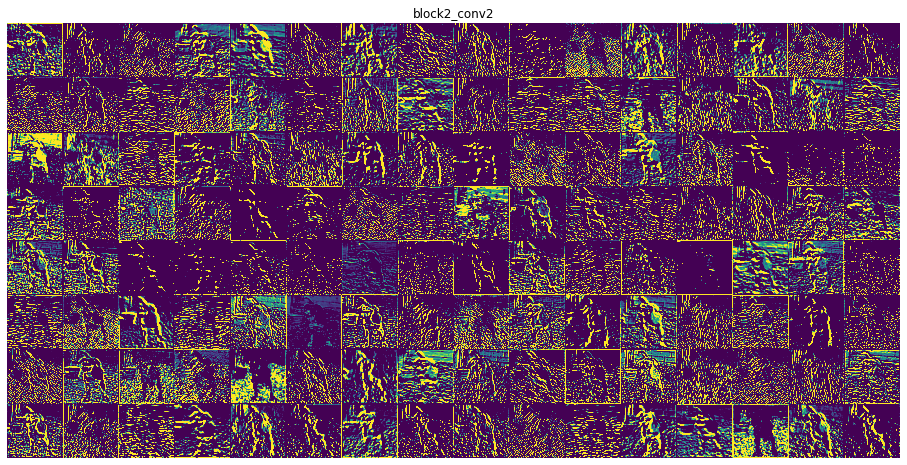

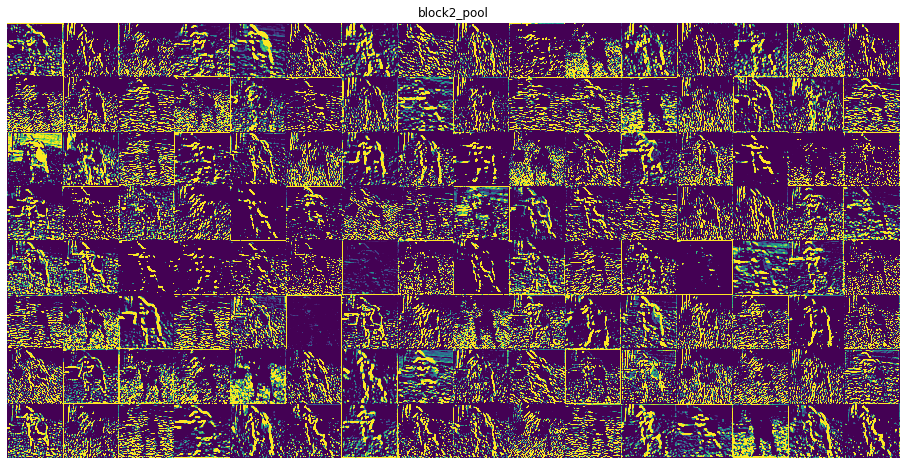

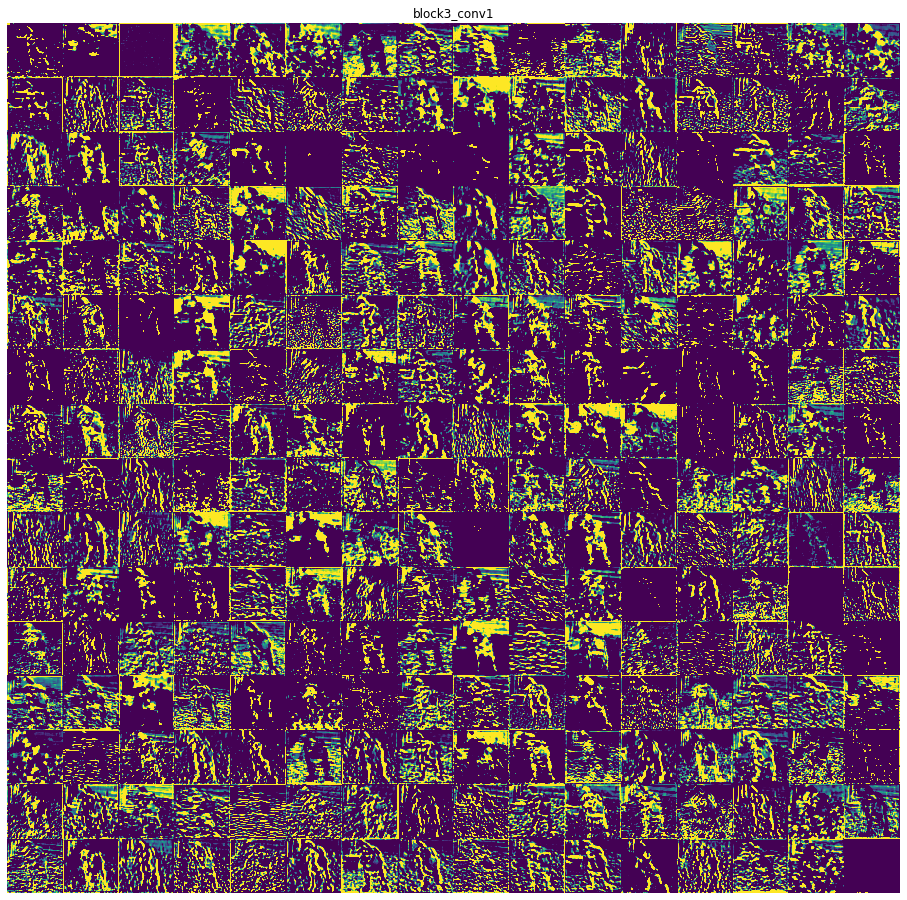

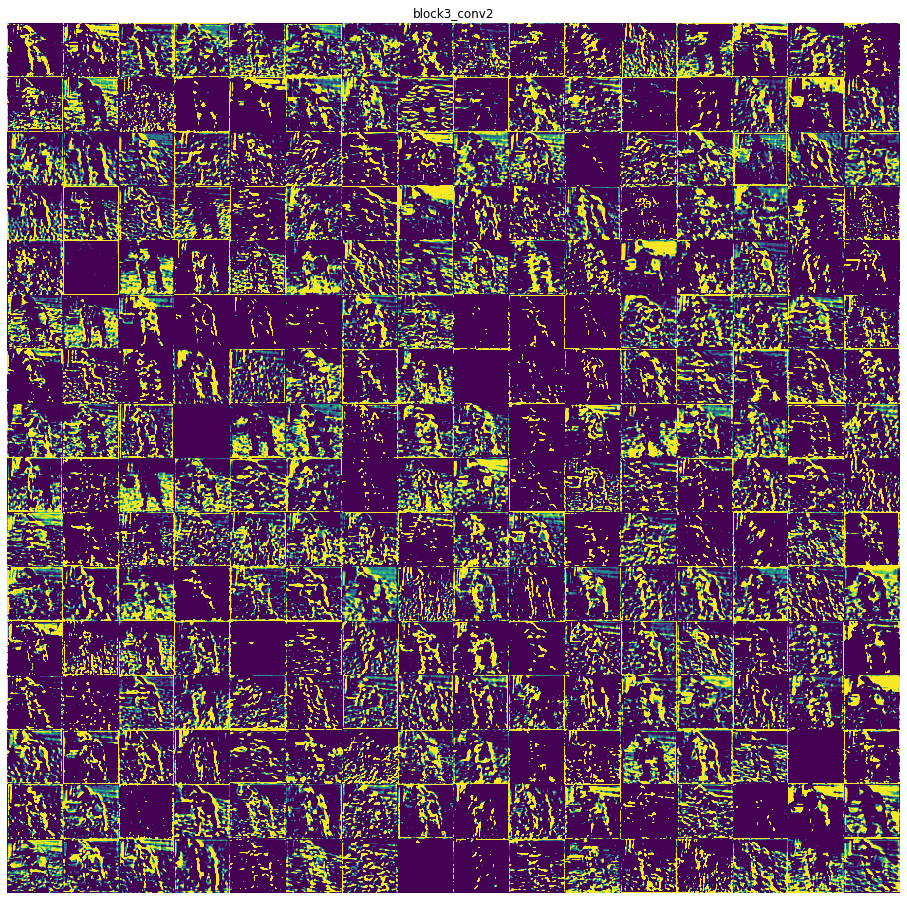

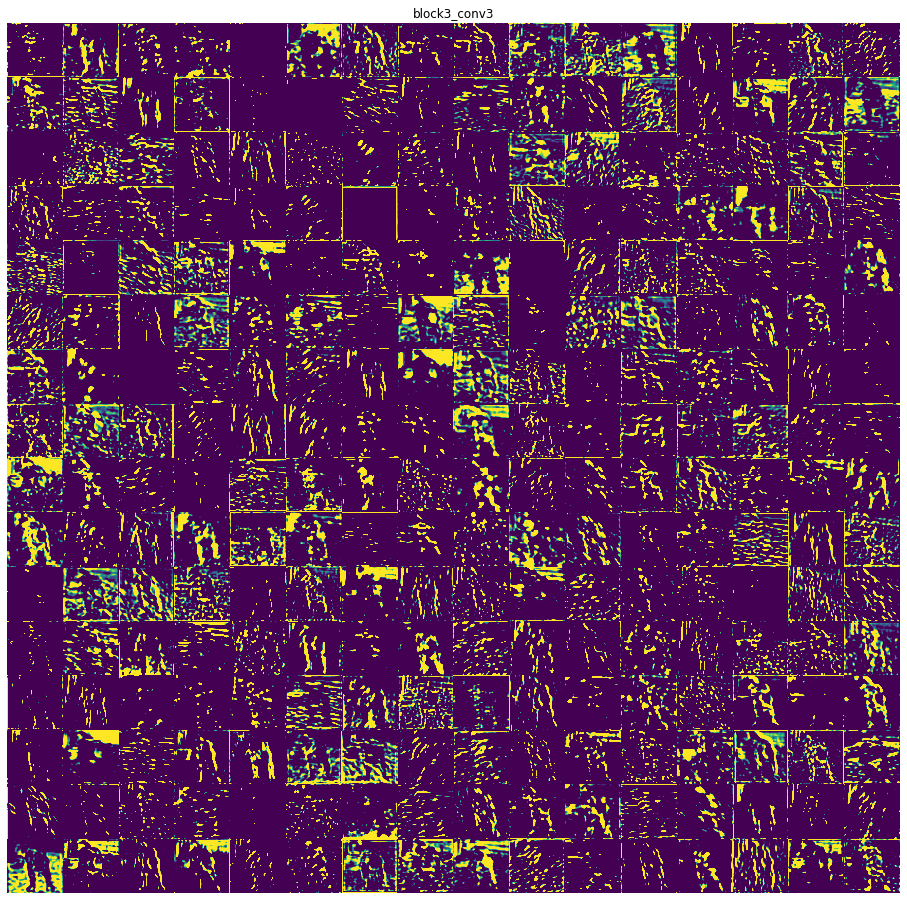

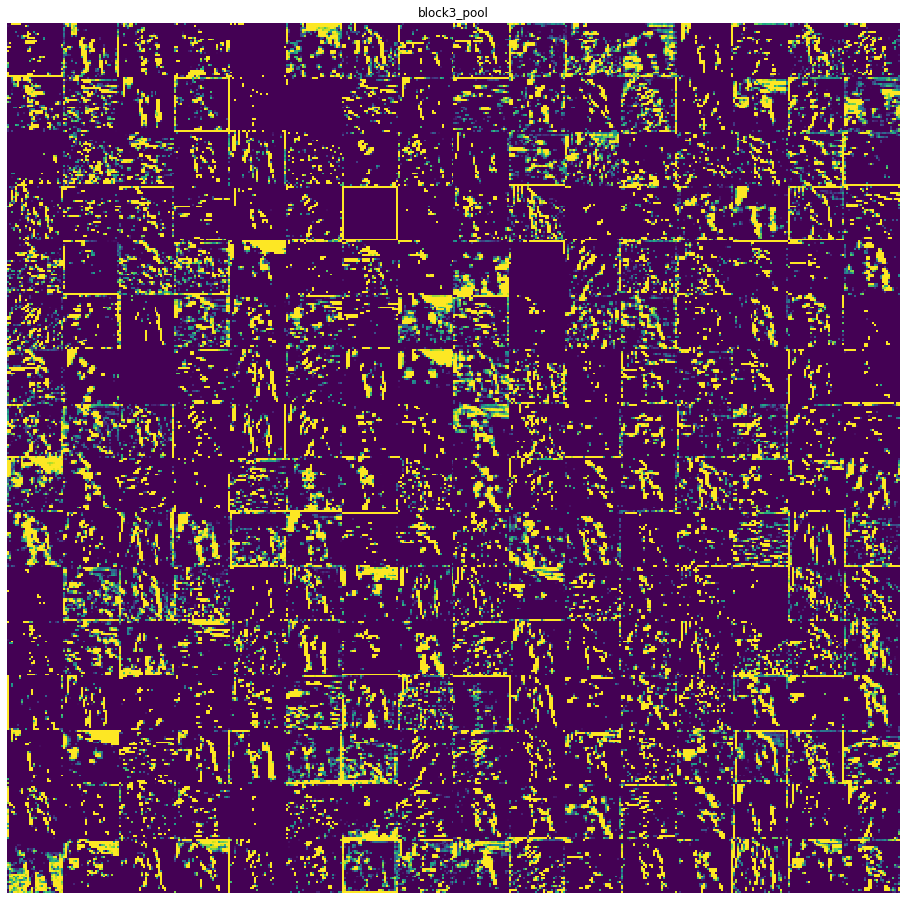

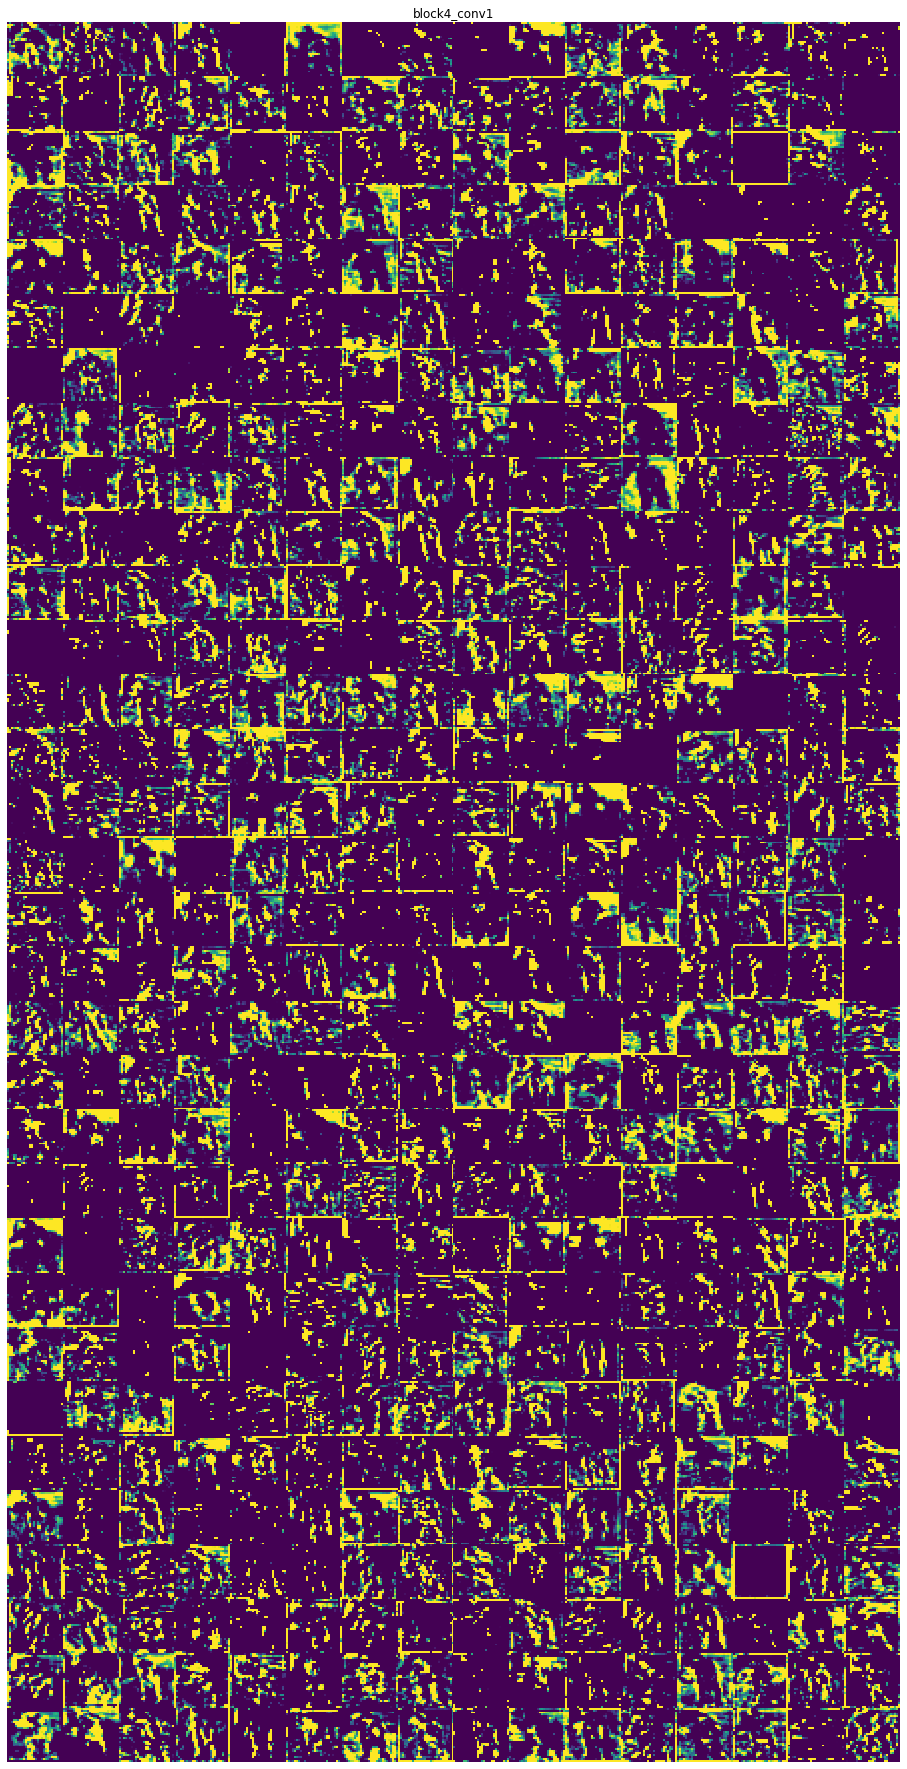

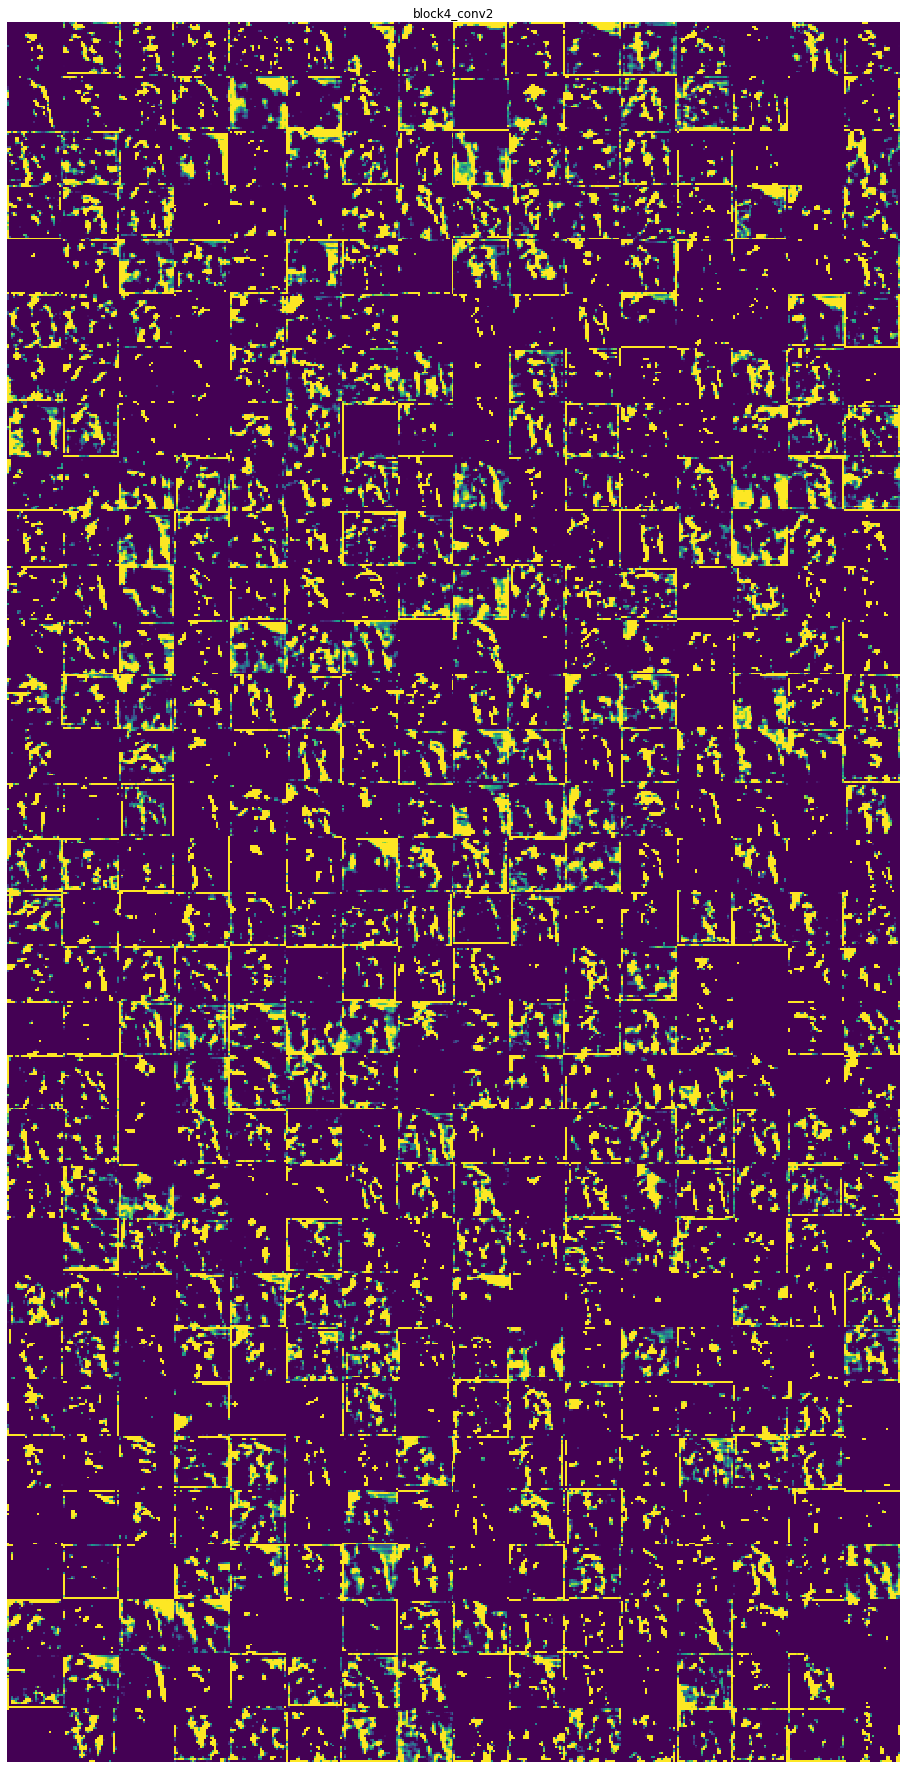

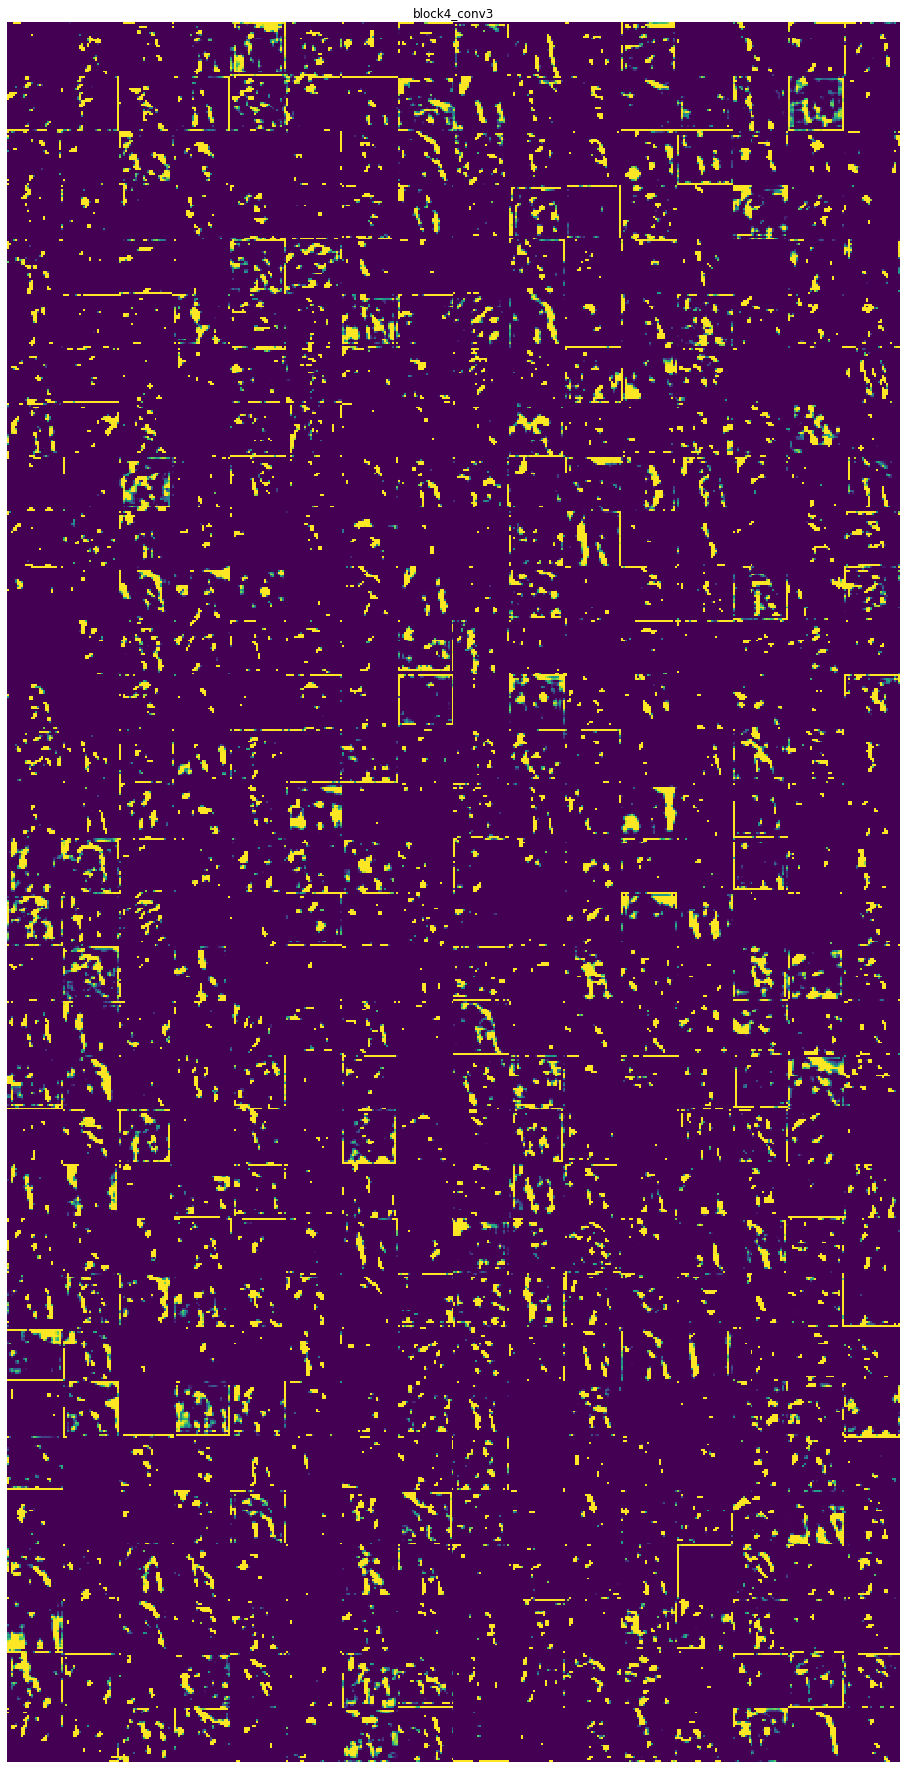

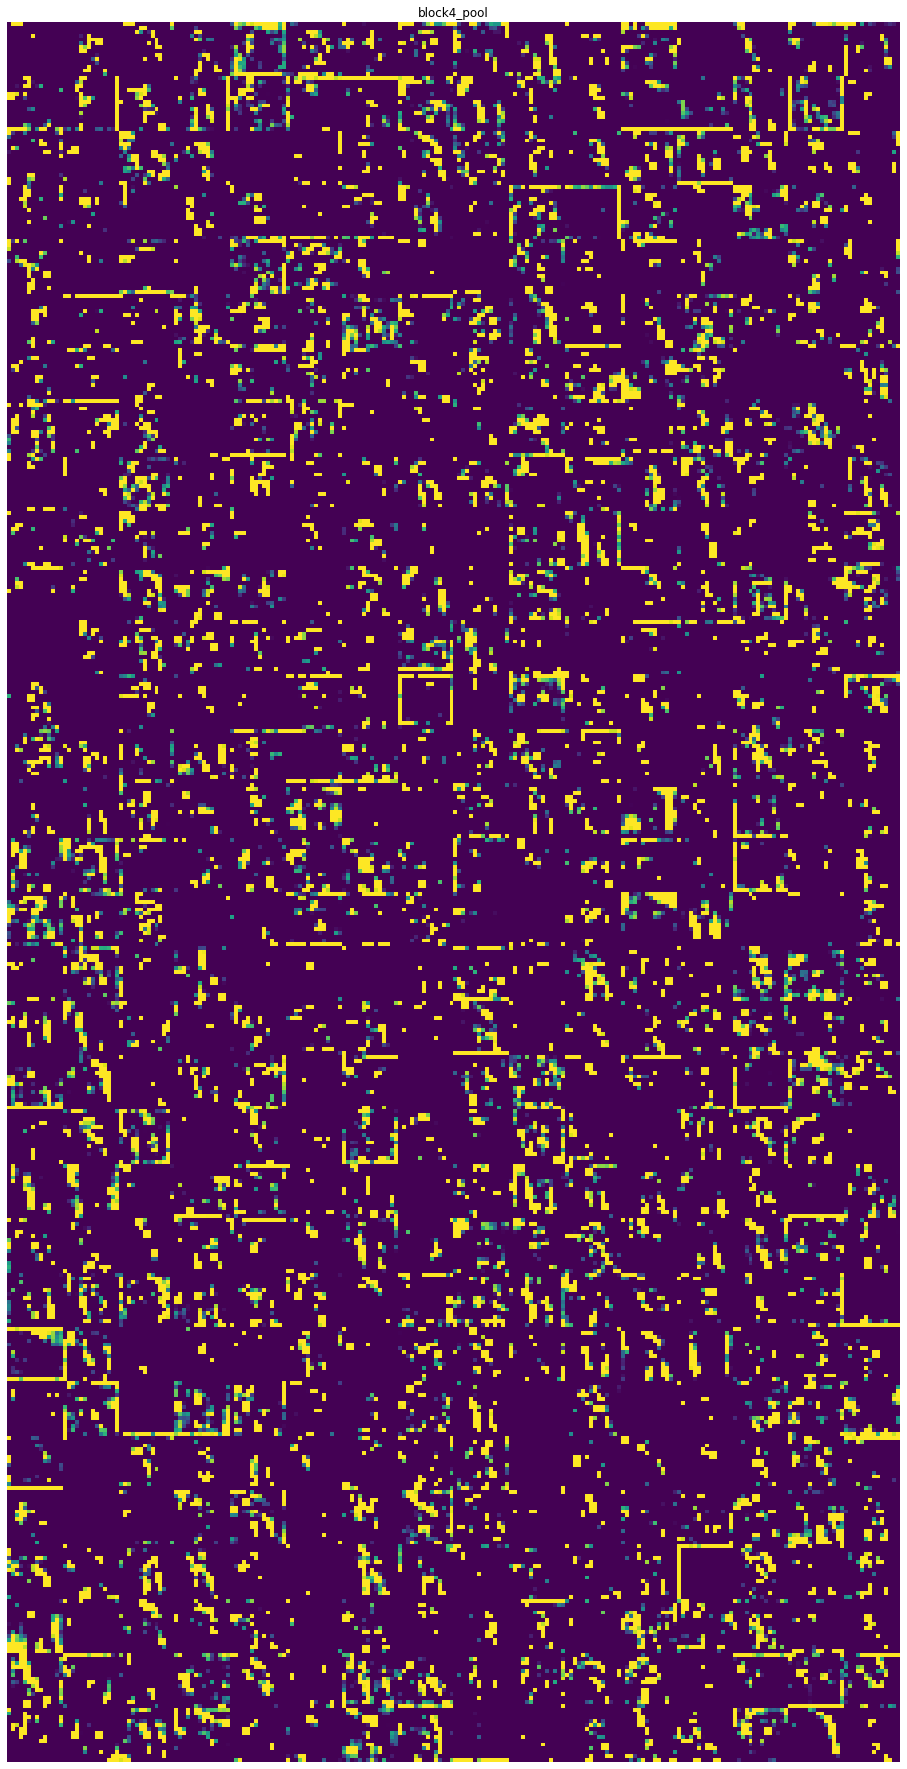

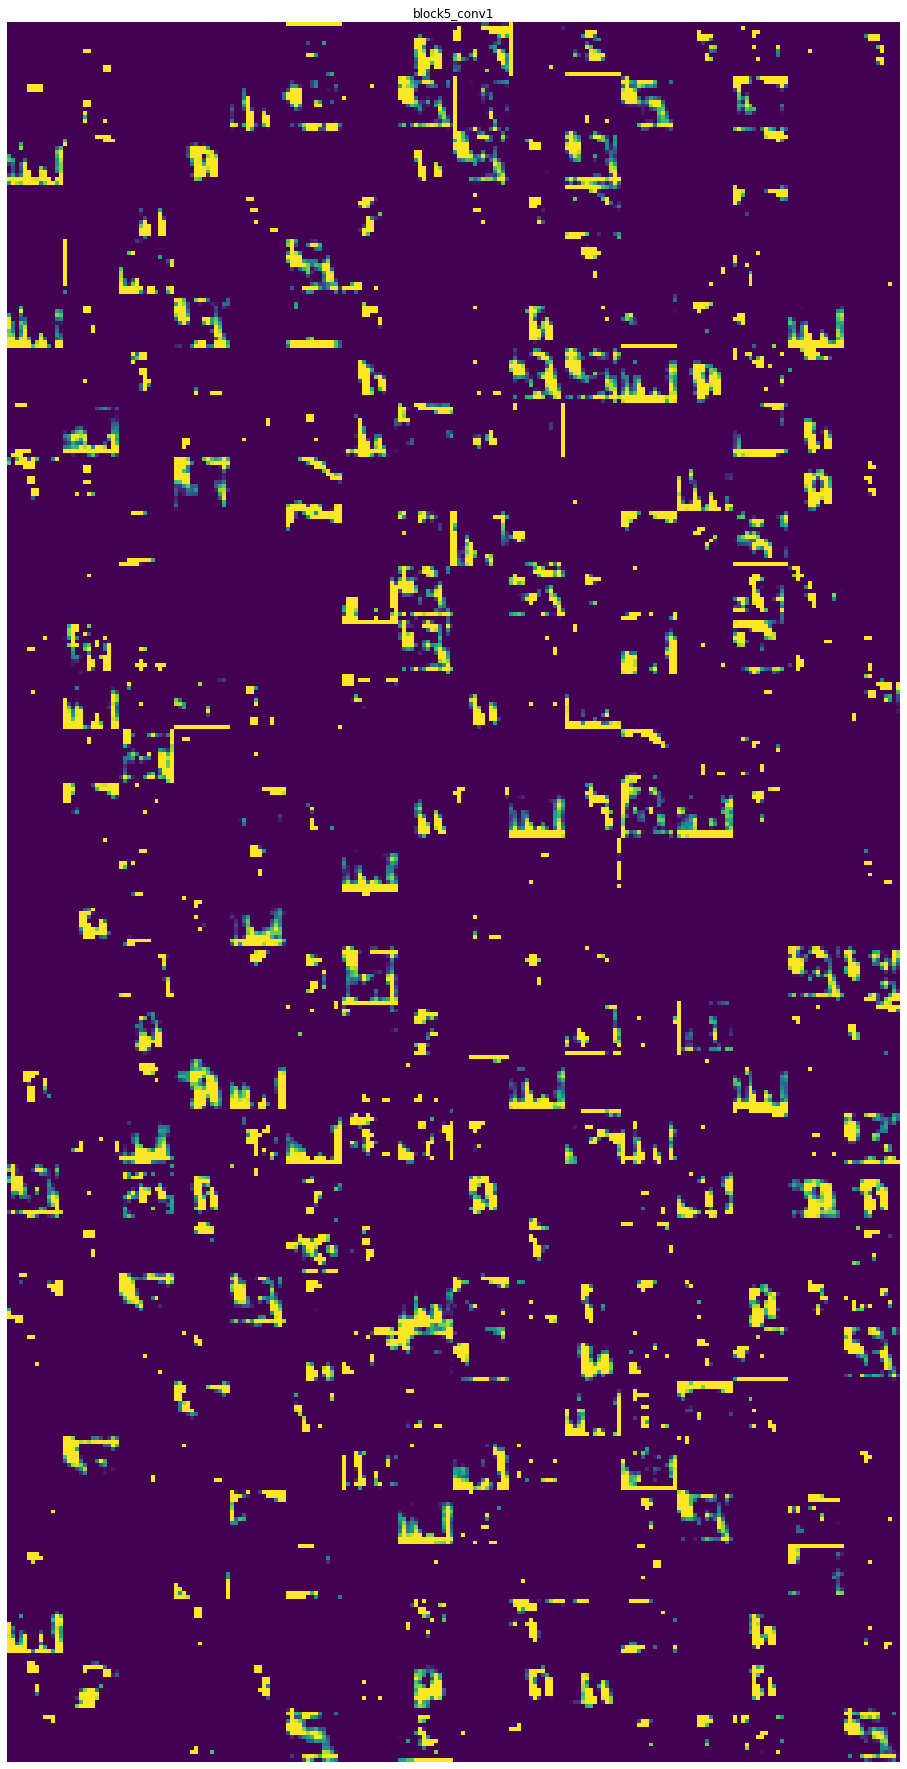

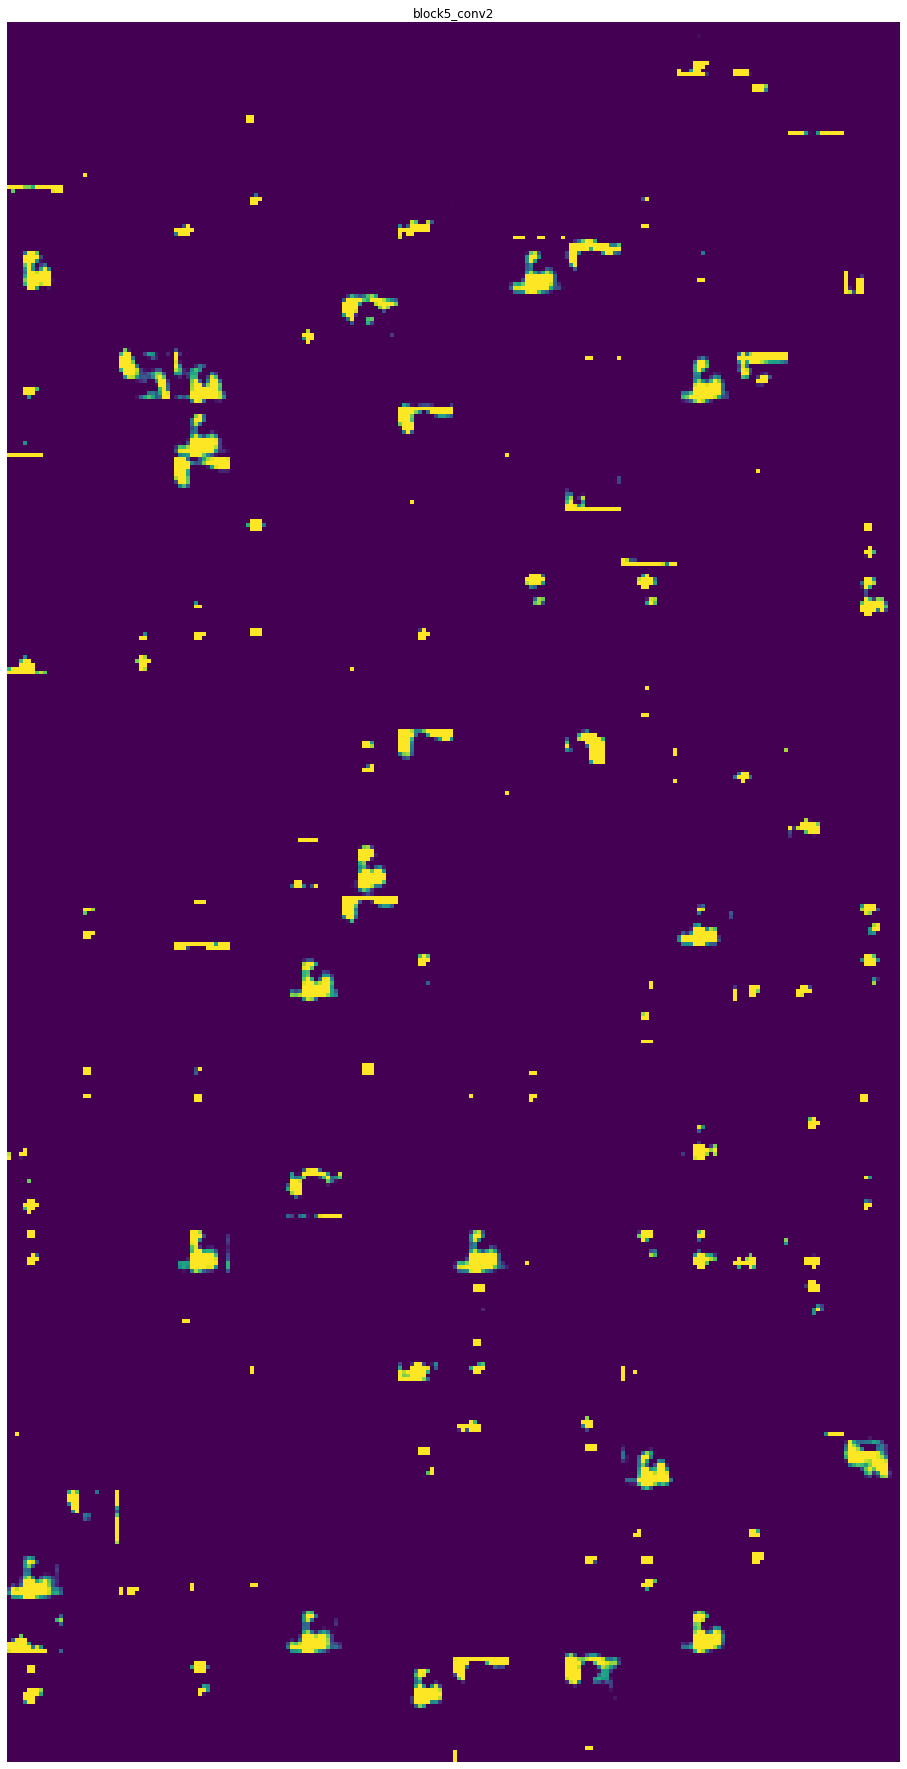

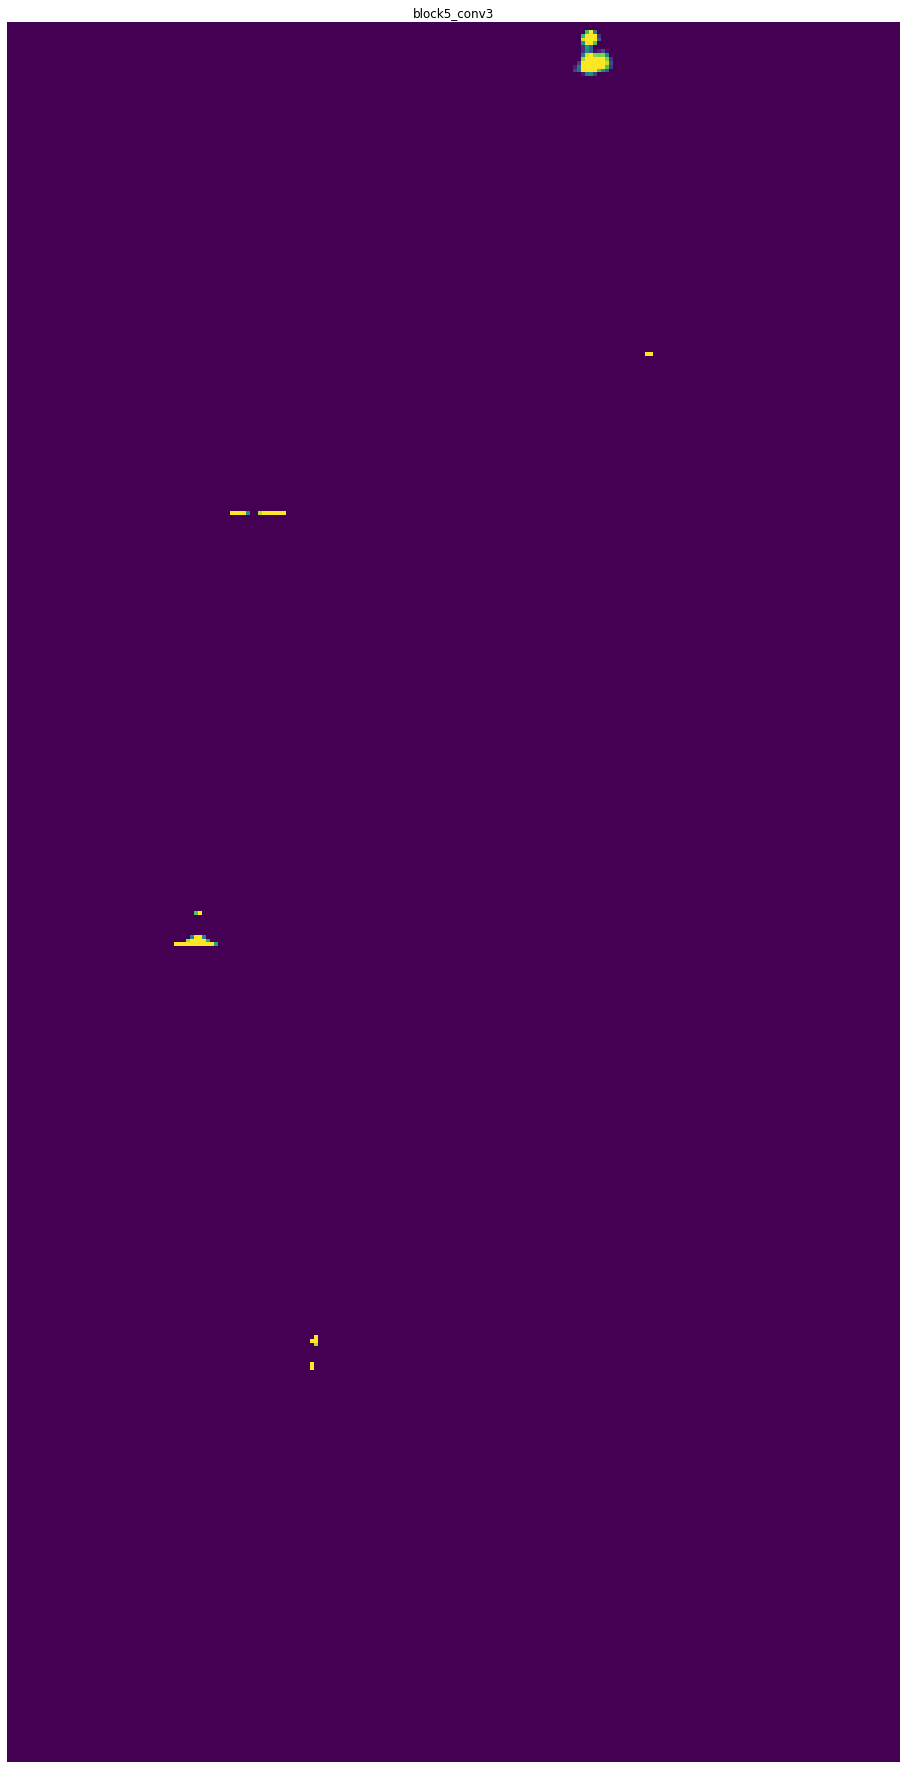

In [ ]:
visualize_intermediate_activations(activations=activations, 
                                   layer_names=layer_names)

# GradCAM (with guided-backprop)

In [ ]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

LAYER_NAME = 'block5_conv3'
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

553467904/553467096 [==============================] - 42s 0us/step


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

CAT_CLASS_INDEX = 281

def filter_fn(image, label): 
  # Filter images to only include cats
  return tf.math.equal(label, 0)

validation_batches = validation_examples.filter(filter_fn).map(format_image).batch(BATCH_SIZE)
for img, _ in validation_batches.shuffle(1000).take(1):
      sample_images = img[:9]    

In [ ]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array(sample_images))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

In [ ]:
cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

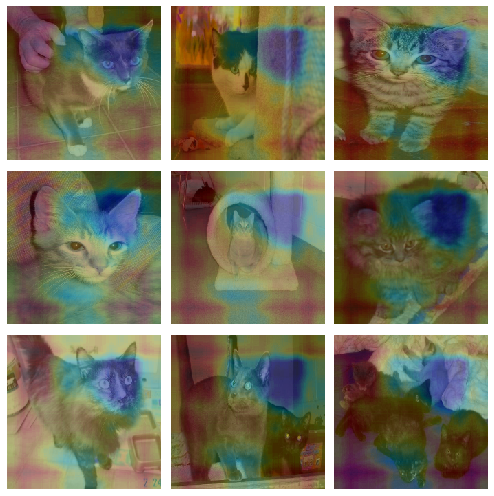

In [ ]:
plt.figure(figsize=(7, 7))
for i in range(3):
  for j in range(3):
    input_img = img[3 * i + j].numpy()
    input_img *= 255
    output_image = cv2.addWeighted(cv2.cvtColor(input_img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.25, 0)

    plt.subplot(3, 3, 3 * i + j + 1)
    plt.imshow(output_image)
    plt.axis('off')

plt.tight_layout()
plt.show()